# XU Method – Entropy-Based Anomaly Detection on CTU-13

Ce Notebook démontre l'approche XU, basée sur l'entropie, sur un dataset de type CTU-13.

## Fonctions utilisées

### 1. Import & Setup

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
%matplotlib inline
sns.set()
print("Libraries loaded.")

#Fonction pour afficher les données
from IPython.display import display, HTML

def display_scrollable_dataframe(df, max_height=400):
    display(HTML(df.to_html(notebook=True)))
    display(HTML(f"""
    <style>
    table {{
        display: block;
        max-height: {max_height}px;
        overflow-y: scroll;
        border: 1px solid #ccc;
    }}
    </style>
    """))



Libraries loaded.


### Chargements des données et Preprocessing

In [37]:
def load_data(data_path):
    df = pd.read_csv(data_path, sep=',', on_bad_lines='skip')
    print(f"Data shape: {df.shape}")
    return df

In [38]:
def preprocess_binetflows(df):
    """
    Harmonise le format du dataset aux standards des algorithmes XU et de classification utilisés précédemment,
    en renommant uniquement les colonnes nécessaires, sans toucher aux colonnes :
    'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes'.

    Conserve le label d'origine dans une colonne 'Label_description'.

    Paramètres :
    - df : DataFrame brut

    Retour :
    - df_clean : DataFrame nettoyé et harmonisé
    """

    print("🔧 Renommage des colonnes au format standard (sans toucher à 'State', 'sTos', 'dTos', etc)...")
    rename_map = {
        'StartTime': 'flow_start',
        'Dur': 'Durat',
        'Proto': 'Prot',
        'SrcAddr': 'SrcIP',
        'Sport': 'SrcPort',
        'Dport': 'DstPort',
        'Dir': 'Direc',  # si tu veux garder l'info de direction
        'DstAddr': 'DstIP'
        # Pas de renommage pour : State, sTos, dTos, TotPkts, TotBytes, SrcBytes
    }

    df_clean = df.rename(columns=rename_map)

    # Conserver les labels d'origine dans une nouvelle colonne
    print("📋 Sauvegarde du label d'origine dans 'Label_description'...")
    df_clean['Label_description'] = df_clean['Label'].astype(str)

    # Harmonisation des labels simplifiés
    print("🧼 Nettoyage des labels (uniquement Background, Normal, Botnet)...")
    df_clean['Label'] = df_clean['Label_description'].apply(lambda x: (
        'Botnet' if 'Botnet' in x else
        'Normal' if 'Normal' in x else
        'Background'
    ))

    # Conversion de flow_start en datetime
    if not pd.api.types.is_datetime64_any_dtype(df_clean['flow_start']):
        print("📅 Conversion de 'flow_start' en datetime...")
        df_clean['flow_start'] = pd.to_datetime(df_clean['flow_start'], errors='coerce')

    print("✅ Dataset prêt pour les traitements XU et classification.")
    return df_clean


In [39]:
def hist_of_label_values(df):
    """
    Affiche un histogramme de la répartition des labels dans le DataFrame,
    avec les pourcentages affichés sur les barres.
    
    Paramètres :
    - df : pd.DataFrame contenant une colonne 'Label' avec les valeurs 
           'Background', 'Normal' et 'Botnet'.
    
    Affichage :
    - Un histogramme avec les pourcentages sur les barres.
    - Un dictionnaire affiché contenant les pourcentages.
    """
    # Regroupement des valeurs
    label_values = df['Label'].value_counts()

    # Somme des catégories
    background_count = sum(label_values[label] for label in label_values.index if "Background" in label)
    normal_count = sum(label_values[label] for label in label_values.index if "Normal" in label)
    botnet_count = sum(label_values[label] for label in label_values.index if "Botnet" in label)
    
    # Dictionnaire des comptages
    label_repartition = {
        "Background traffic": background_count, 
        "Normal traffic": normal_count, 
        "Botnet traffic": botnet_count
    }

    # Calcul du total et des pourcentages
    total_traffic = sum(label_repartition.values())
    percentage_of_traffic = {k: round((v / total_traffic) * 100, 2) for k, v in label_repartition.items()}

    # Affichage de l'histogramme
    fig, ax = plt.subplots(figsize=(7,5))
    bars = ax.bar(label_repartition.keys(), label_repartition.values(), color=['gray', 'blue', 'red'])

    # Ajout des pourcentages au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_traffic) * 100
        ax.text(bar.get_x() + bar.get_width()/2, height + total_traffic * 0.02, 
                f"{percentage:.2f}%", ha='center', fontsize=12, fontweight='bold')

    # Amélioration du visuel
    ax.set_ylabel("Nombre de flux", fontsize=12)
    ax.set_title("Répartition du trafic par catégorie", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()


In [40]:
def plot_label_distribution_separated(df_classified_netflows, time_col='TimeWindow', x_tick_spacing=5, label_to_show=['Botnet', 'Normal', 'Background']):
    """
    Affiche un graphe séparé (non empilé) du nombre de flux pour chaque label par TimeWindow.

    Paramètres :
    - df_classified_netflows : DataFrame contenant 'TimeWindow' et 'Label'
    - time_col : nom de la colonne temporelle (par défaut 'TimeWindow')
    - x_tick_spacing : espacement des ticks X (ex: 5 = 1 tick toutes les 5 TimeWindows)
    """
    print("📊 ➤ Calcul de la distribution des labels par TimeWindow (graphes séparés)...")

    # Conversion TimeWindow en label lisible
    df_classified_netflows['TimeLabel'] = df_classified_netflows[time_col].dt.strftime('%H:%M')

    # Comptage des labels par TimeWindow
    label_counts = df_classified_netflows.groupby(['TimeLabel', 'Label']).size().unstack(fill_value=0)

    # Ajouter les labels manquants si nécessaire
    for label in label_to_show:
        if label not in label_counts.columns:
            label_counts[label] = 0

    label_counts = label_counts[label_to_show]

    # Création des sous-graphes
    n = len(label_to_show)
    fig, axes = plt.subplots(n, 1, figsize=(18, 4 * n), sharex=True)

    if n == 1:
        axes = [axes]

    # Espacement des ticks X
    x_ticks = np.arange(0, len(label_counts), x_tick_spacing)
    x_labels = label_counts.index[x_ticks]

    for i, label in enumerate(label_to_show):
        axes[i].bar(label_counts.index, label_counts[label], color=('red' if label == 'Botnet' else 'blue' if label == 'Normal' else 'gray'))
        axes[i].set_title(f"Activité '{label}' au fil du temps", fontsize=14)
        axes[i].set_ylabel("Nombre de flux")
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.6)
        axes[i].set_xticks(x_ticks)
        axes[i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

    axes[-1].set_xlabel("Heure (TimeWindow)", fontsize=12)
    plt.tight_layout()
    plt.show()

In [41]:
def show_botnet_ip_adress(df):
    print("Adresses IP des Botnets")
    display_scrollable_dataframe(pd.DataFrame(df[df["Label"] == "Botnet"]["SrcIP"].value_counts()).head(20))

### Algorithme XU

#### Algorithme d'extraction des clusters significatif par rapport à l'IP

In [42]:
def compute_relative_uncertainty(prob_dist):
    probs = np.array(prob_dist)
    if len(probs) <= 1:
        return 0.0
    entropy = -np.sum(probs * np.log2(probs + 1e-12))
    max_entropy = np.log2(len(probs))
    return entropy / max_entropy

def extract_significant_clusters_with_live_plot(df, column='SrcIP', alpha0=0.02, beta=0.9, debug=False, live_plot=True):
    """
    Extraction des clusters significatifs + affichage final des courbes à la fin de l’algorithme.
    """
    print(f"📊 ➤ Extraction des clusters significatifs sur colonne '{column}'")

    freqs = df[column].value_counts(normalize=True)
    A = freqs.index.tolist()
    PA = freqs.to_dict()

    S = set()
    R = set(A)
    k = 0
    alpha = alpha0

    log = []
    total_values_list = []
    significant_values_list = []
    alpha_list = []

    PR = [PA[val] for val in R]
    theta = compute_relative_uncertainty(PR)

    while theta <= beta:
        alpha = alpha0 * (0.5 ** k)
        k += 1

        move_to_S = {val for val in R if PA[val] >= alpha}
        S.update(move_to_S)
        R -= move_to_S

        # ✅ Normalisation de PR
        PR_probs = [PA[val] for val in R]
        PR_probs = np.array(PR_probs)
        PR_probs = PR_probs / PR_probs.sum() if PR_probs.sum() > 0 else np.array([1.0])  # éviter division par 0

        theta = compute_relative_uncertainty(PR_probs)

        if debug:
            print(f"\n🔁 Iteration {k}")
            print(f"  ➤ Alpha: {round(alpha, 5)}")
            print(f"  ➤ RU(R): {round(theta, 5)}")
            print(f"  ➤ |S|={len(S)} | |R|={len(R)} | Move_to_S={len(move_to_S)}")

        total_values_list.append(len(A))
        significant_values_list.append(len(S))
        alpha_list.append(alpha)
        log.append({
            'Iteration': k,
            'Alpha': alpha,
            'RU_remaining': theta,
            'Total_Values': len(A),
            'Significant_Values': len(S),
        })

    alpha_star = alpha

    # Ajout des clusters dans le dataset
    df_clustered = df.copy()
    df_clustered['ClusterType'] = df_clustered[column].apply(lambda x: 'Significatif' if x in S else 'Bruit')
    df_log = pd.DataFrame(log)

    print(f"\n✅ Extraction terminée : {len(S)} clusters significatifs extraits. α* final = {alpha_star}")
    print("📌 Liste des valeurs significatives (S) :")
    for i, val in enumerate(sorted(S)):
        print(f"   - {i+1:03d}: {val}")

    if live_plot:
        # 📈 Plots à la fin seulement
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

        iterations = list(range(1, k + 1))

        ax1.plot(iterations, total_values_list, 'b--', label='Total values')
        ax1.plot(iterations, significant_values_list, 'r-', label='Significant values')
        ax1.set_yscale('log')
        ax1.set_title(" Total vs Significant Values")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Number of values (log scale)")
        ax1.legend()
        ax1.grid(True)

        ax2.plot(iterations, alpha_list, 'r-', label='Alpha threshold')
        ax2.set_title(" Évolution du seuil α")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Alpha")
        ax2.grid(True)

        plt.show()

    return S, R, alpha_star, df_clustered, df_log


#### Fonction XU de calcul de distance par rapport aux BC

In [43]:
def normalized_entropy(series):
    """
    Calcule l'entropie normalisée (Relative Uncertainty - RU).
    """
    counts = series.value_counts(normalize=True, dropna=False)
    entropy = -(counts * np.log2(counts + 1e-12)).sum()
    distinct = len(counts)
    total = len(series)

    if distinct <= 1 or total <= 1:
        return 0.0

    max_entropy = np.log2(min(distinct, total))
    return float(entropy / max_entropy)

def XU_algorithm(df, ref_profiles):
    """
    Algorithme XU.
    Calcul des distances comme la somme des carrés des différences d'entropies normalisées (RU).

    Paramètres :
    - df : DataFrame NetFlows (doit contenir 'SrcIP', 'SrcPort', 'DstPort', 'DstIP', 'Label')
    - ref_profiles : dict des profils de référence : {'nom': [RU_srcPort, RU_dstPort, RU_dstIP]}

    Retour :
    - df_features : DataFrame contenant RU, distances aux profils, et score d’anomalie
    """

    results = []
    ip_groups = df.groupby('SrcIP')

    print(f"➤ Traitement de {len(ip_groups)} adresses IP sources...")

    for src_ip, df_src in tqdm(ip_groups, desc="Analyse XU"):
        ru_srcport = normalized_entropy(df_src['SrcPort'].fillna('N/A'))
        ru_dstport = normalized_entropy(df_src['DstPort'].fillna('N/A'))
        ru_dstip   = normalized_entropy(df_src['DstIP'].fillna('N/A'))

        label = 'Botnet' if 'Botnet' in df_src['Label'].unique() else (
                'Normal' if 'Normal' in df_src['Label'].unique() else 'Background'
        )

        ru_vector = np.array([ru_srcport, ru_dstport, ru_dstip])

        distances = {}
        for profile_name, profile_vector in ref_profiles.items():
            dist = ((ru_vector - profile_vector) ** 2).sum()  # sans racine carrée
            distances[f'Distance_{profile_name.capitalize()}'] = dist

        # Anomaly Score = minimum distance aux profils connus
        min_distance = min(distances.values())

        result_row = {
            'SrcIP': src_ip,
            'RU_SrcPort': ru_srcport,
            'RU_DstPort': ru_dstport,
            'RU_DstIP': ru_dstip,
            'AnomalyScore': min_distance,
            'Label': label,
            'ClusterType': df_src['ClusterType'].values[0] if 'ClusterType' in df_src.columns else 'N/A'
        }
        result_row.update(distances)
        results.append(result_row)

    df_features = pd.DataFrame(results)
    print("✅ XU terminé.")
    return df_features



def apply_threshold_and_categorize_ru(df_features, threshold=0.5, epsilon_dict=None):
    """
    - Applique le seuil de classification sur la colonne 'Mean_Distance'
    - Catégorise chaque RU en Low (0), Medium (1), High (2) selon epsilon_dict
    - Insère les colonnes RU_*_Level juste après leur colonne RU_* correspondante

    Paramètres :
    - df_features : DataFrame avec les colonnes RU_* et Mean_Distance
    - threshold : seuil pour prédiction de 'Botnet' ou 'Normal'
    - epsilon_dict : dictionnaire des epsilon, ex: {'RU_SrcPort': 0.2, 'RU_DstPort': 0.2, 'RU_DstIP': 0.3}

    Retour :
    - df : DataFrame enrichi avec 'Predicted' + colonnes de niveau
    """

    df = df_features.copy()
    df['Predicted'] = df['AnomalyScore'].apply(lambda d: 'Botnet' if d < threshold else 'Normal')

    if epsilon_dict is None:
        epsilon_dict = {
            'RU_SrcPort': 0.2,
            'RU_DstPort': 0.2,
            'RU_DstIP': 0.3
        }

    def categorize_ru(ru_value, epsilon):
        if ru_value <= epsilon:
            return 0  # Low
        elif ru_value >= 1 - epsilon:
            return 2  # High
        else:
            return 1  # Medium

    # Insérer chaque RU_Level juste après la RU correspondante
    for col in ['RU_SrcPort', 'RU_DstPort', 'RU_DstIP']:
        if col in df.columns:
            level_col = col + '_Level'
            df[level_col] = df[col].apply(lambda x: categorize_ru(x, epsilon_dict.get(col, 0.2)))
            
            # Réorganiser les colonnes : insérer level_col juste après col
            cols = list(df.columns)
            col_idx = cols.index(col)
            # Retirer puis insérer à la bonne position
            cols.remove(level_col)
            cols.insert(col_idx + 1, level_col)
            df = df[cols]

    return df




#### Fonctions d'appartenance aux BC

In [44]:
def apply_threshold_and_categorize_ru(df_features, threshold=0.5, epsilon_dict=None):
    """
    - Applique le seuil de classification sur la colonne 'Mean_Distance'
    - Catégorise chaque RU en Low (0), Medium (1), High (2) selon epsilon_dict
    - Insère les colonnes RU_*_Level juste après leur colonne RU_* correspondante

    Paramètres :
    - df_features : DataFrame avec les colonnes RU_* et Mean_Distance
    - threshold : seuil pour prédiction de 'Botnet' ou 'Normal'
    - epsilon_dict : dictionnaire des epsilon, ex: {'RU_SrcPort': 0.2, 'RU_DstPort': 0.2, 'RU_DstIP': 0.3}

    Retour :
    - df : DataFrame enrichi avec 'Predicted' + colonnes de niveau
    """

    df = df_features.copy()
    df['Predicted'] = df['AnomalyScore'].apply(lambda d: 'Botnet' if d < threshold else 'Normal')

    if epsilon_dict is None:
        epsilon_dict = {
            'RU_SrcPort': 0.2,
            'RU_DstPort': 0.2,
            'RU_DstIP': 0.3
        }

    def categorize_ru(ru_value, epsilon):
        if ru_value <= epsilon:
            return 0  # Low
        elif ru_value >= 1 - epsilon:
            return 2  # High
        else:
            return 1  # Medium

    # Insérer chaque RU_Level juste après la RU correspondante
    for col in ['RU_SrcPort', 'RU_DstPort', 'RU_DstIP']:
        if col in df.columns:
            level_col = col + '_Level'
            df[level_col] = df[col].apply(lambda x: categorize_ru(x, epsilon_dict.get(col, 0.2)))
            
            # Réorganiser les colonnes : insérer level_col juste après col
            cols = list(df.columns)
            col_idx = cols.index(col)
            # Retirer puis insérer à la bonne position
            cols.remove(level_col)
            cols.insert(col_idx + 1, level_col)
            df = df[cols]

    return df

#### Fonctions d'affichage des scores d'anomalies

In [64]:
def plot_anomly_distributions(df_classified_pre_clusters):
    """
    Affiche les distributions des scores d'anomalie pour les IP Botnet, Normales et Background.
    """    
    # Filtrer les IP selon le label
    botnet_scores_df = df_classified_pre_clusters[df_classified_pre_clusters['Label'] == 'Botnet'][['SrcIP', 'AnomalyScore', 'ClusterType']].reset_index(drop=True)
    normal_scores_df = df_classified_pre_clusters[df_classified_pre_clusters['Label'] == 'Normal'][['SrcIP', 'AnomalyScore', 'ClusterType']].reset_index(drop=True)
    background_scores_df = df_classified_pre_clusters[df_classified_pre_clusters['Label'] == 'Background'][['SrcIP', 'AnomalyScore', 'ClusterType']].reset_index(drop=True)

    # ➤ Calcul des bornes communes d'AnomalyScore
    min_score = min(
        botnet_scores_df['AnomalyScore'].min(),
        normal_scores_df['AnomalyScore'].min(),
        background_scores_df['AnomalyScore'].min()
    )

    max_score = max(
        botnet_scores_df['AnomalyScore'].max(),
        normal_scores_df['AnomalyScore'].max(),
        background_scores_df['AnomalyScore'].max()
    )

    # Créer les subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    # Histogramme Botnet
    kde_botnet = botnet_scores_df['AnomalyScore'].nunique() > 1
    sns.histplot(data=botnet_scores_df, x='AnomalyScore', hue='ClusterType', bins=30, kde=kde_botnet, ax=axes[0])
    axes[0].set_title("Distribution des scores d'anomalie - IP Botnet")
    axes[0].set_xlabel("Anomaly Score")
    axes[0].set_ylabel("Nombre d'adresses IP")
    axes[0].set_xlim(min_score, max_score)
    axes[0].grid(True)

    # Histogramme Normal
    sns.histplot(normal_scores_df, x='AnomalyScore',hue='ClusterType', bins=30, kde=True, ax=axes[1])
    axes[1].set_title("Distribution des scores d'anomalie - IP Normales")
    axes[1].set_xlabel("Anomaly Score")
    axes[1].set_ylabel("Nombre d'adresses IP")
    axes[1].set_xlim(min_score, max_score)
    axes[1].grid(True)

    # Histogramme Background
    sns.histplot(background_scores_df,x='AnomalyScore',hue='ClusterType', bins=30, kde=True, ax=axes[2])
    axes[2].set_title("Distribution des scores d'anomalie - IP Background")
    axes[2].set_xlabel("Anomaly Score")
    axes[2].set_ylabel("Nombre d'adresses IP (échelle logarithmique)")
    axes[2].set_yscale('log')
    axes[2].set_xlim(min_score, max_score)
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


### Training : Fonctions d'extraction de clusters et d'affichage des clusters 

In [66]:
def find_best_k_with_silhouette(df_xu, k_range=range(2, 11)):
    """
    Applique KMeans uniquement sur les IP Botnet, avec les features RU, et calcule les scores de silhouette.
    Génère aussi automatiquement les profils des clusters (custom_profiles) au format prêt à copier.

    Paramètres :
    - df_xu : DataFrame contenant les résultats XU (avec 'Label', 'RU_SrcPort', 'RU_DstPort', 'RU_DstIP')
    - k_range : plage de valeurs de k à tester (par défaut 2 à 10)

    Retour :
    - silhouette_scores : dict {k: score}
    - best_k : valeur de k avec meilleur score
    - kmeans_model : modèle KMeans entraîné avec best_k
    - df_botnet_clustered : df des IP Botnet avec leur cluster associé
    - custom_profiles : dictionnaire des centroïdes au format {nom: vecteur RU}
    """
    print("🔍 ➤ Filtrage des IP Botnet pour clustering...")
    df_botnet = df_xu[df_xu['Label'] == 'Botnet'].copy()
    features = df_botnet[['RU_SrcPort', 'RU_DstPort', 'RU_DstIP']].values

    silhouette_scores = {}
    best_score = -1
    best_k = None
    best_model = None

    print("📈 ➤ Évaluation des scores de silhouette...")
    for k in tqdm(k_range):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        cluster_labels = kmeans.fit_predict(features)
        score = silhouette_score(features, cluster_labels)
        silhouette_scores[k] = score
        print(f"  ➤ k={k}, silhouette={round(score, 4)}")
        if score > best_score:
            best_score = score
            best_k = k
            best_model = kmeans

    # Affichage du graphe silhouette
    plt.figure(figsize=(10, 5))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', linestyle='-')
    plt.title("Score de silhouette pour chaque nombre de clusters k")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score de silhouette")
    plt.grid(True)
    plt.xticks(list(silhouette_scores.keys()))
    plt.tight_layout()
    plt.show()

    # Appliquer le meilleur clustering sur les IP Botnet
    df_botnet['Cluster'] = best_model.predict(features)

    print(f"\n✅ Meilleur nombre de clusters : k={best_k} (score={round(best_score, 4)})")

    # Génération des profils
    print("\n📦 ➤ Custom profiles (copier-coller ready au format JSON-like):")
    custom_profiles = {}
    for i, centroid in enumerate(best_model.cluster_centers_):
        profile_name = f"cluster_{i}"
        profile_vector = np.round(centroid, 3).tolist()
        custom_profiles[profile_name] = profile_vector

    print("custom_profiles = ")
    print(json.dumps(custom_profiles, indent=4))

    return silhouette_scores, best_k, best_model, df_botnet, custom_profiles


In [47]:
def plot_botnet_clusters_3D_plotly(df_botnet_clustered, kmeans_model):
    """
    Plot interactif 3D des clusters Botnet avec Plotly.
    """
    print("\n📍 ➤ Coordonnées des centroïdes trouvés (features RU):")
    for i, centroid in enumerate(kmeans_model.cluster_centers_):
        print(f"  ➤ Cluster {i} : RU_SrcPort={centroid[0]:.3f}, RU_DstPort={centroid[1]:.3f}, RU_DstIP={centroid[2]:.3f}")

    # Trace des points Botnet clusterisés
    fig = go.Figure()

    for cluster_id in df_botnet_clustered['Cluster'].unique():
        cluster_data = df_botnet_clustered[df_botnet_clustered['Cluster'] == cluster_id]
        fig.add_trace(go.Scatter3d(
            x=cluster_data['RU_SrcPort'],
            y=cluster_data['RU_DstPort'],
            z=cluster_data['RU_DstIP'],
            mode='markers',
            name=f'Cluster {cluster_id}',
            marker=dict(size=5)
        ))

    # Trace des centroïdes
    centers = kmeans_model.cluster_centers_
    fig.add_trace(go.Scatter3d(
        x=centers[:, 0], y=centers[:, 1], z=centers[:, 2],
        mode='markers',
        marker=dict(size=2, color='black', symbol='x'),
        name='Centroides'
    ))

    fig.update_layout(
        title='📊 Clustering des IP Botnet (3D RU features)',
        scene=dict(
            xaxis_title='RU_SrcPort',
            yaxis_title='RU_DstPort',
            zaxis_title='RU_DstIP'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


### Fonctions d'évaluation de performances

#### Fonctions résultats SrcIP XU to single netflows

In [48]:
def classify_netflows_from_XU(df, df_classified, time_window='2Min'):
    """
    Injecte les classifications de df_classified dans le dataset netflow df via SrcIP,
    puis regroupe par SrcIP et TimeWindow.

    Paramètres :
    - df : DataFrame brut des NetFlows (doit contenir 'SrcIP' et 'flow_start')
    - df_classified : DataFrame avec les colonnes ['SrcIP', 'Predicted'] issues de df_features
    - time_window : granularité temporelle utilisée pour regrouper les flows (par défaut 2 minutes)

    Retour :
    - df_classified_netflows : DataFrame df avec ajout des colonnes Predicted et TimeWindow
    - df_grouped : DataFrame agrégé par SrcIP et TimeWindow, prêt pour les métriques
    """

    print("[1/5] 📅 Vérification du format de la colonne 'flow_start'...")
    if not pd.api.types.is_datetime64_any_dtype(df['flow_start']):
        df['flow_start'] = pd.to_datetime(df['flow_start'], format='%H:%M:%S.%f', errors='coerce')
        print("✅ Conversion de 'flow_start' terminée.")
    else:
        print("✅ 'flow_start' déjà au format datetime.")

    print("[2/5] 🕒 Attribution des TimeWindows...")
    df['TimeWindow'] = df['flow_start'].dt.floor(time_window)

    print("[3/5] 🔗 Jointure des classifications par 'SrcIP'...")
    df_classified_netflows = df.merge(df_classified[['SrcIP', 'Predicted']], on='SrcIP', how='left')
    missing_preds = df_classified_netflows['Predicted'].isna().sum()

    # 🔧 Remplissage des valeurs manquantes par 'Normal'
    df_classified_netflows['Predicted'] = df_classified_netflows['Predicted'].fillna('Normal')

    print("[4/5] 📊 Regroupement par 'SrcIP' et 'TimeWindow' (aggregation)...")
    tqdm.pandas(desc="→ Agrégation des netflows")
    df_grouped = df_classified_netflows.groupby(['SrcIP', 'TimeWindow']).progress_apply(
        lambda group: pd.Series({
            'Predicted': group['Predicted'].mode()[0] if not group['Predicted'].mode().empty else 'Unknown',
            'Label': group['Label'].mode()[0] if not group['Label'].mode().empty else 'Unknown',
            'FlowCount': len(group)
        })
    ).reset_index()

    print("[5/5] ✅ Classification et agrégation terminées.")

    return df_classified_netflows, df_grouped


#### Fonction de calcul des métriques temporelles et affichage

In [49]:
def compute_time_weighted_metrics(df_features, take_background=True, alpha=0.01):
    """
    Calcule les métriques réseau temporellement pondérées + métriques classiques (FPR, TPR, etc.)
    pour la sortie de l'algorithme XU, en mode IP-based detection.

    Paramètres :
    - df_features : DataFrame issu de XU_algorithm (avec colonnes TimeWindow, SrcIP, Label, Predicted)
    - alpha : paramètre de pondération temporelle pour la correcting function
    - take_background : inclut ou non les lignes Background dans les métriques

    Retour :
    - df_metrics : DataFrame des métriques par TimeWindow
    - average_metrics : dictionnaire des moyennes globales
    """
    metrics = []
    df_features = df_features.copy()

    # Filtrer le Background si demandé
    if not take_background:
        df_features = df_features[df_features['Label'] != 'Background']

    # Ordre des TimeWindows
    unique_windows = sorted(df_features['TimeWindow'].unique())
    window_index_map = {w: i for i, w in enumerate(unique_windows)}

    for window in unique_windows:
        df_win = df_features[df_features['TimeWindow'] == window]
        idx = window_index_map[window]

        correcting_weight = np.exp(-alpha * idx) + 1

        # Étape 1 : regroupement par SrcIP —> IP-based detection
        df_ip = df_win.groupby('SrcIP').agg({
            'Label': lambda x: 'Botnet' if 'Botnet' in x.values else (
                'Normal'),
            'Predicted': lambda x: 'Botnet' if 'Botnet' in x.values else (
                'Normal')
        }).reset_index()


        true_labels = df_ip['Label']
        pred_labels = df_ip['Predicted']

        # Comptage des erreurs IP-based
        c_TP = ((true_labels == 'Botnet') & (pred_labels == 'Botnet')).sum()
        c_TN = ((true_labels == 'Normal') & (pred_labels == 'Normal')).sum()
        c_FP = ((true_labels == 'Normal') & (pred_labels == 'Botnet')).sum()
        c_FN = ((true_labels == 'Botnet') & (pred_labels == 'Normal')).sum()


        n_botnet_ips = max((true_labels == 'Botnet').sum(), 1)
        n_normal_ips = max((true_labels == 'Normal').sum(), 1)
        n_background_ips = max((true_labels == 'Background').sum(), 1) if take_background else 0
        # Pondération
        tTP = (c_TP * correcting_weight) / n_botnet_ips
        tFN = (c_FN * correcting_weight) / n_botnet_ips
        tFP = c_FP / (n_normal_ips+n_background_ips)
        tTN = c_TN / (n_normal_ips+n_background_ips)

        # Calcul des métriques
        FPR = tFP / (tTN + tFP) if (tTN + tFP) != 0 else 0
        TPR = tTP / (tTP + tFN) if (tTP + tFN) != 0 else 0
        TNR = tTN / (tTN + tFP) if (tTN + tFP) != 0 else 0
        FNR = tFN / (tTP + tFN) if (tTP + tFN) != 0 else 0
        Precision = tTP / (tTP + tFP) if (tTP + tFP) != 0 else 0
        Accuracy = (tTP + tTN) / (tTP + tTN + tFP + tFN) if (tTP + tTN + tFP + tFN) != 0 else 0
        ErrorRate = (tFP + tFN) / (tTP + tTN + tFP + tFN) if (tTP + tTN + tFP + tFN) != 0 else 0
        F1 = (2 * Precision * TPR) / (Precision + TPR) if (Precision + TPR) != 0 else 0

        metrics.append({
            'TimeWindow': window,
            'c_TP': c_TP, 'c_FN': c_FN, 'c_FP': c_FP, 'c_TN': c_TN,
            'tTP': tTP, 'tFN': tFN, 'tFP': tFP, 'tTN': tTN,
            'FPR': FPR, 'TPR': TPR, 'TNR': TNR, 'FNR': FNR,
            'Precision': Precision, 'Accuracy': Accuracy,
            'ErrorRate': ErrorRate, 'F1_Score': F1
        })

    df_metrics = pd.DataFrame(metrics)

    average_metrics = {
        'Sum_tTP': df_metrics['tTP'].sum(),
        'Sum_tTN': df_metrics['tTN'].sum(),
        'Sum_tFP': df_metrics['tFP'].sum(),
        'Sum_tFN': df_metrics['tFN'].sum(),
        'Avg_TPR': df_metrics['TPR'].mean(),
        'Avg_TNR': df_metrics['TNR'].mean(),
        'Avg_FPR': df_metrics['FPR'].mean(),
        'Avg_FNR': df_metrics['FNR'].mean(),
        'Avg_Prec': df_metrics['Precision'].mean(),
        'Avg_Acc': df_metrics['Accuracy'].mean(),
        'Avg_ErrR': df_metrics['ErrorRate'].mean(),
        'Avg_FM1': df_metrics['F1_Score'].mean()
    }

    return df_metrics, average_metrics, df_ip


In [50]:
def plot_botnet_and_metrics_subplots(df_classified_netflows, df_metrics, x_tick_spacing=4):
    """
    Affiche en sous-graphes :
    1. Le nombre d’IP Botnet actives (réelles) par TimeWindow.
    2. Les métriques XU classiques (TPR, FPR, etc.) au fil du temps.

    Paramètres :
    - df_classified_netflows : DataFrame avec colonnes ['TimeWindow', 'SrcIP', 'Label']
    - df_metrics : DataFrame avec les colonnes métriques par TimeWindow
    - x_tick_spacing : espacement des ticks X (int)
    """

    print("📊 ➤ Fusion : Botnet Activity + XU Metrics")

    # ────────────── Nombres de bots Actifs (Ground Truth) ──────────────
    all_timewindows = df_classified_netflows['TimeWindow'].dropna().sort_values().unique()
    all_time_df = pd.DataFrame({'TimeWindow': all_timewindows})

    botnet_flows = df_classified_netflows[df_classified_netflows['Label'] == 'Botnet']
    botnet_activity = botnet_flows.groupby('TimeWindow')['SrcIP'].nunique().reset_index(name='BotnetUniqueIPs')

    # Ajouter les TimeWindows manquants avec 0
    botnet_activity = all_time_df.merge(botnet_activity, on='TimeWindow', how='left').fillna(0)
    botnet_activity['BotnetUniqueIPs'] = botnet_activity['BotnetUniqueIPs'].astype(int)
    botnet_activity['TimeLabel'] = botnet_activity['TimeWindow'].dt.strftime('%H:%M')


    # ────────────── Préparer df_metrics ──────────────
    df_plot = df_metrics.copy().sort_values('TimeWindow')
    df_plot['TimeLabel'] = df_plot['TimeWindow'].dt.strftime('%H:%M')


    metrics_to_plot = ['BotnetUniqueIPs', 'c_TP', 'c_FN', 'c_FP', 'c_TN',
                       'TPR', 'FPR', 'TNR', 'FNR', 'Precision', 'Accuracy', 'ErrorRate', 'F1_Score']

    n_metrics = len(metrics_to_plot)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(18, 3 * n_metrics), sharex=False)

    # Préparer les ticks X (partagés)
    x_ticks = np.arange(0, len(df_plot['TimeLabel']), x_tick_spacing)
    x_tick_labels = df_plot['TimeLabel'].iloc[x_ticks]

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        if metric == 'BotnetUniqueIPs':
            sns.lineplot(data=botnet_activity, x='TimeLabel', y='BotnetUniqueIPs', ax=ax)
            ax.set_title(" IP Botnet actives par TimeWindow", loc='left')
            ax.set_ylabel("Nbre IP Botnet")
            ax.set_ylim(-0.1, 11)
        else:
            sns.lineplot(data=df_plot, x='TimeLabel', y=metric, ax=ax)
            ax.set_title(f"{metric} vs Time", loc='left')
            ax.set_ylabel(metric)
            ax.set_ylim(-0.1, 1.2 if metric not in ['BotnetUniqueIPs', 'c_TP', 'c_FN', 'c_FP', 'c_TN'] else None)

        ax.grid(True)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_tick_labels, rotation=45, ha='right', fontsize=9)
        ax.set_xlabel("Heure")

    plt.tight_layout()
    plt.show()

## Pipelines d'exécution

In [51]:
# Chemin vers un fichier .binetflow
data_path = "dataset/capture20110818_10.binetflow"
df = load_data(data_path)
display_scrollable_dataframe(df.head(), max_height=200)

Data shape: (1309791, 15)


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


In [52]:
df = preprocess_binetflows(df)
display_scrollable_dataframe(df.head(20), max_height=200)

🔧 Renommage des colonnes au format standard (sans toucher à 'State', 'sTos', 'dTos', etc)...
📋 Sauvegarde du label d'origine dans 'Label_description'...
🧼 Nettoyage des labels (uniquement Background, Normal, Botnet)...
📅 Conversion de 'flow_start' en datetime...
✅ Dataset prêt pour les traitements XU et classification.


,flow_start,Durat,Prot,SrcIP,SrcPort,Direc,DstIP,DstPort,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Label_description
0,2011-08-18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,Background,flow=Background-TCP-Attempt
1,2011-08-18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,Background,flow=Background-TCP-Attempt
2,2011-08-18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,Background,flow=Background-TCP-Established
3,2011-08-18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt
4,2011-08-18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt
5,2011-08-18 10:27:57.611601,1.179357,tcp,94.44.60.103,49905,->,147.32.84.118,6881,S_RA,0.0,0.0,4,268,148,Background,flow=Background-TCP-Attempt
6,2011-08-18 10:28:15.463038,1.140237,tcp,2.159.127.100,1378,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,Background,flow=Background-TCP-Attempt
7,2011-08-18 10:28:37.132447,12.058948,tcp,213.233.154.219,36381,->,147.32.84.229,13363,SRA_SA,0.0,0.0,7,508,208,Background,flow=Background-TCP-Established
8,2011-08-18 10:29:03.150806,0.942243,tcp,88.212.37.169,62055,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,Background,flow=Background-TCP-Attempt
9,2011-08-18 10:29:43.750355,3.547213,tcp,95.210.161.212,58571,->,147.32.84.118,6881,S_RA,0.0,0.0,8,488,248,Background,flow=Background-TCP-Attempt


Label
Background    1187592
Botnet         106352
Normal          15847
Name: count, dtype: int64


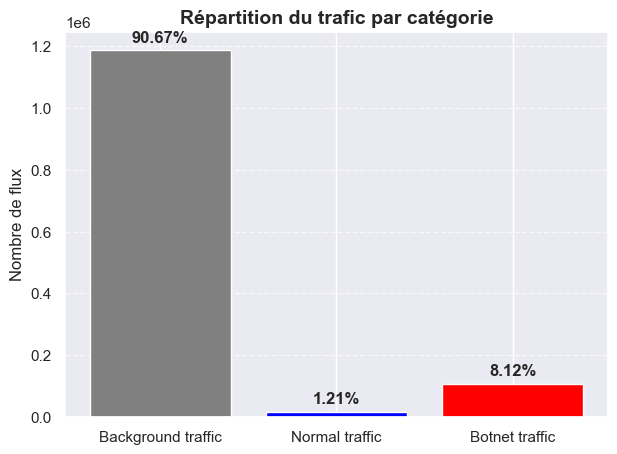

In [56]:
print(df['Label'].value_counts())
hist_of_label_values(df)

📊 ➤ Calcul de la distribution des labels par TimeWindow (graphes séparés)...


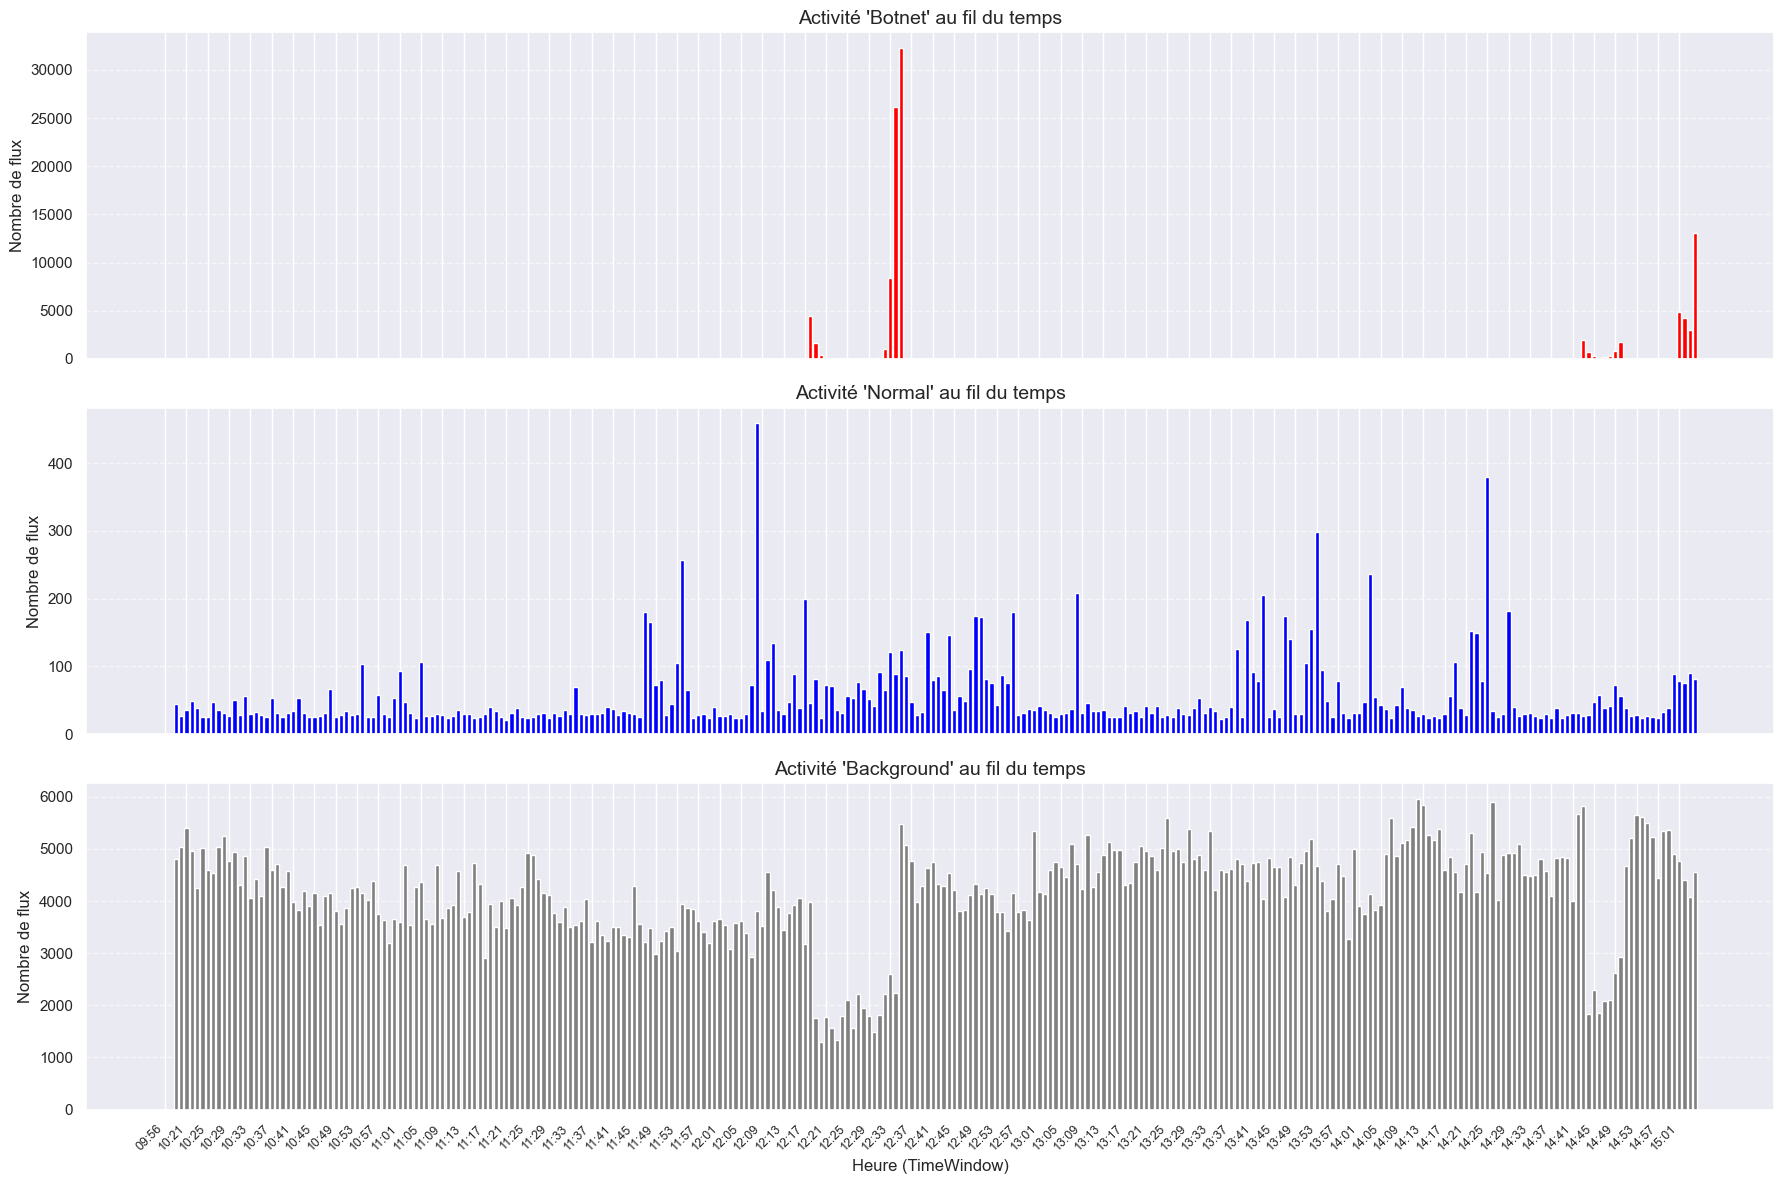

In [57]:
plot_label_distribution_separated(df, time_col="flow_start", x_tick_spacing=4, label_to_show=['Botnet', 'Normal', 'Background'])

In [58]:
show_botnet_ip_adress(df)

Adresses IP des Botnets


,count
SrcIP,
147.32.84.205,11874
147.32.84.206,11287
147.32.84.204,11159
147.32.84.208,11118
147.32.84.207,10581
147.32.84.191,10454
147.32.84.192,10397
147.32.84.193,10009
147.32.84.209,9894


📊 ➤ Extraction des clusters significatifs sur colonne 'SrcIP'

✅ Extraction terminée : 48 clusters significatifs extraits. α* final = 0.0025
📌 Liste des valeurs significatives (S) :
   - 001: 147.32.84.118
   - 002: 147.32.84.132
   - 003: 147.32.84.138
   - 004: 147.32.84.164
   - 005: 147.32.84.165
   - 006: 147.32.84.170
   - 007: 147.32.84.191
   - 008: 147.32.84.192
   - 009: 147.32.84.193
   - 010: 147.32.84.204
   - 011: 147.32.84.205
   - 012: 147.32.84.206
   - 013: 147.32.84.207
   - 014: 147.32.84.208
   - 015: 147.32.84.209
   - 016: 147.32.84.229
   - 017: 147.32.84.59
   - 018: 147.32.84.68
   - 019: 147.32.84.94
   - 020: 147.32.84.95
   - 021: 147.32.85.124
   - 022: 147.32.85.24
   - 023: 147.32.85.25
   - 024: 147.32.85.26
   - 025: 147.32.85.30
   - 026: 147.32.85.34
   - 027: 147.32.85.60
   - 028: 147.32.85.7
   - 029: 147.32.85.8
   - 030: 147.32.85.88
   - 031: 147.32.85.89
   - 032: 147.32.86.111
   - 033: 147.32.86.114
   - 034: 147.32.86.116
   - 035: 147.32.8

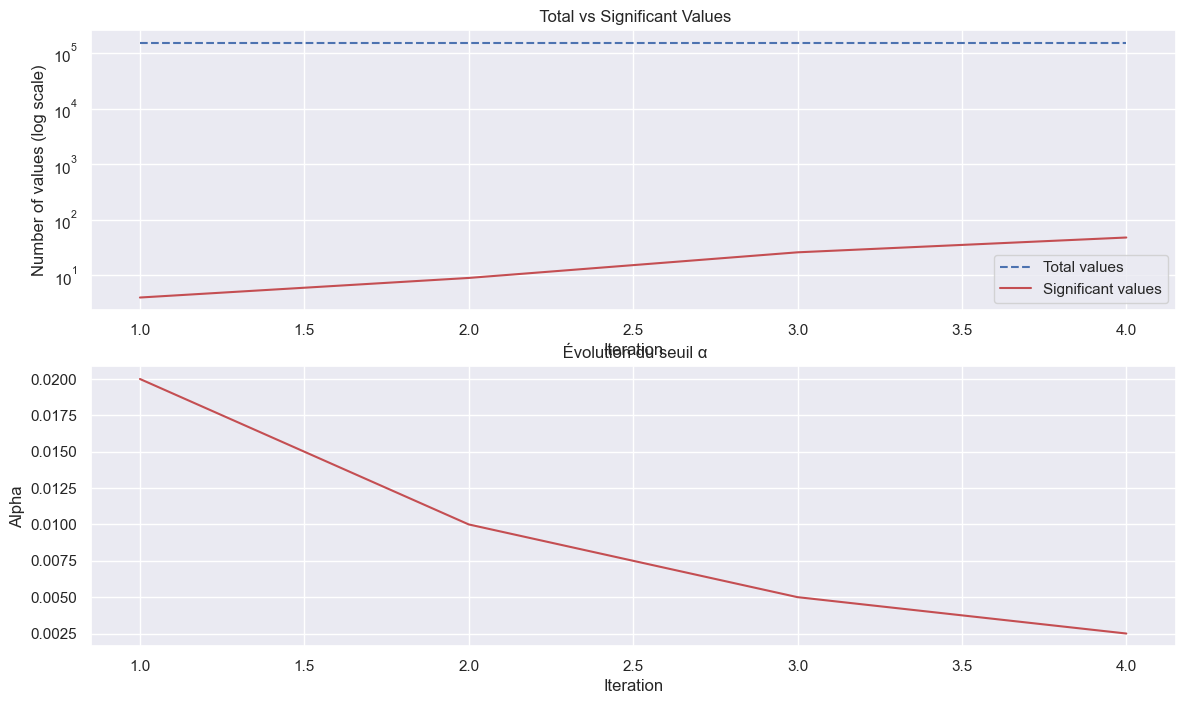


🔍 Nombre de lignes retenues pour l’analyse XU : 870667
 📊 ➤ Analyse XU sur les clusters significatifs...
➤ Traitement de 48 adresses IP sources...


Analyse XU:   0%|          | 0/48 [00:00<?, ?it/s]

✅ XU terminé.


,SrcIP,RU_SrcPort,RU_DstPort,RU_DstIP,AnomalyScore,Label,ClusterType,Distance_Scanner_simple,Distance_Scanner_bruyant,Distance_Victime_multiattaque,Distance_Scanner_intermediaire,Distance_Cible_botnet,Distance_Scanner_vertical
0,147.32.84.118,0.880758,0.262773,0.806082,0.035686,Background,Significatif,0.644899,0.035686,1.024463,0.674681,0.065468,0.525417
1,147.32.84.132,0.993698,0.404808,0.433739,0.213069,Background,Significatif,1.109004,0.319087,1.261312,1.025158,0.235240,0.213069
2,147.32.84.138,0.993439,0.002507,0.002739,0.027695,Background,Significatif,1.612815,0.823313,2.408804,1.850809,1.061307,0.027695
3,147.32.84.164,0.877382,0.389595,0.428427,0.192242,Normal,Significatif,0.910569,0.306758,1.087216,0.838892,0.235082,0.192242
4,147.32.84.165,0.970355,0.092190,0.011203,0.012896,Botnet,Significatif,1.547539,0.794971,2.200036,1.713787,0.961220,0.012896
5,147.32.84.170,0.993326,0.409853,0.385080,0.185989,Normal,Significatif,1.159183,0.369861,1.303418,1.071301,0.281979,0.185989
6,147.32.84.191,0.972989,0.085044,0.010086,0.013636,Botnet,Significatif,1.554282,0.797499,2.218212,1.726247,0.969464,0.013636
7,147.32.84.192,0.972890,0.084848,0.008962,0.013830,Botnet,Significatif,1.556114,0.799491,2.220358,1.728236,0.971613,0.013830
8,147.32.84.193,0.971888,0.088307,0.010677,0.013283,Botnet,Significatif,1.551221,0.796199,2.209929,1.720575,0.965554,0.013283
9,147.32.84.204,0.974572,0.079770,0.008767,0.014294,Botnet,Significatif,1.559583,0.800267,2.231951,1.735767,0.976451,0.014294


 📊 ➤ Analyse XU sur toutes les IP pour les statistiques
➤ Traitement de 151256 adresses IP sources...


Analyse XU:   0%|          | 0/151256 [00:00<?, ?it/s]

✅ XU terminé.


,SrcIP,RU_SrcPort,RU_DstPort,RU_DstIP,AnomalyScore,Label,ClusterType,Distance_Scanner_simple,Distance_Scanner_bruyant,Distance_Victime_multiattaque,Distance_Scanner_intermediaire,Distance_Cible_botnet,Distance_Scanner_vertical
0,0.0.0.0,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000
1,00:0b:ac:c4:e7:40,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000
2,00:0b:ac:c5:cf:00,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000
3,00:0c:29:97:a3:eb,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000
4,00:15:17:2c:e5:2d,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000
5,1.112.121.154,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000
6,1.112.182.132,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000
7,1.112.197.149,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000
8,1.112.217.186,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000
9,1.112.30.35,0.0,0.000000,0.0,0.830000,Background,Bruit,0.830000,1.630000,1.630000,1.070000,1.870000,0.830000


In [63]:
# --- 1. Étape : Extraction des clusters significatifs sur une colonne (par ex. 'SrcIP')
S, R, alpha_star, df_clustered, df_log = extract_significant_clusters_with_live_plot(
    df, column='SrcIP', alpha0=0.02, beta=0.8, debug=False
)

# --- 2. Filtrage du dataset : uniquement les lignes appartenant aux clusters significatifs
df_significatif = df_clustered[df_clustered['ClusterType'] == 'Significatif']

print(f"\n🔍 Nombre de lignes retenues pour l’analyse XU : {len(df_significatif)}")

# --- 3. Application de l’algorithme XU uniquement sur ce sous-ensemble

custom_profiles = {
    # Comportements typiques de botnets/scanners identifiés :
    
    # BC2 [0,0,2] → Scan horizontal basique / botnet scanner simple
    'scanner_simple': np.array([0.1, 0.1, 0.9]),

    # BC20 [2,0,2] → Scanner bruyant, srcPrt aléatoires, dstIP massifs
    'scanner_bruyant': np.array([0.9, 0.1, 0.9]),

    # BC8 [0,2,2] → Réponse d’une victime potentiellement exposée à divers scanners
    'victime_multiattaque': np.array([0.1, 0.9, 0.9]),

    # BC5 [0,1,2] → Scan un peu plus varié, intermédiaire
    'scanner_intermediaire': np.array([0.1, 0.5, 0.9]),

    # BC23 [2,1,2] → Profil de service fortement ciblé par des scanners massifs
    'cible_botnet': np.array([0.9, 0.5, 0.9]),

    # BC 18 [2,0,0] → Training dataset 10
    'scanner_vertical': np.array([0.9, 0.1, 0.1]),
}

print(" 📊 ➤ Analyse XU sur les clusters significatifs...")
df_features = XU_algorithm(df_significatif, ref_profiles=custom_profiles)
display_scrollable_dataframe(df_features, max_height=200)

print(" 📊 ➤ Analyse XU sur toutes les IP pour les statistiques")
df_features_without_pre_cluster = XU_algorithm(df_clustered, ref_profiles=custom_profiles)
display_scrollable_dataframe(df_features_without_pre_cluster.head(20), max_height=200)

🔍 ➤ Filtrage des IP Botnet pour clustering...
📈 ➤ Évaluation des scores de silhouette...


  0%|          | 0/8 [00:00<?, ?it/s]

  ➤ k=2, silhouette=0.583
  ➤ k=3, silhouette=0.6216
  ➤ k=4, silhouette=0.5619
  ➤ k=5, silhouette=0.4513
  ➤ k=6, silhouette=0.451
  ➤ k=7, silhouette=0.2731
  ➤ k=8, silhouette=0.1668
  ➤ k=9, silhouette=0.135


c:\Users\kira\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kira\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\kira\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kira\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\U

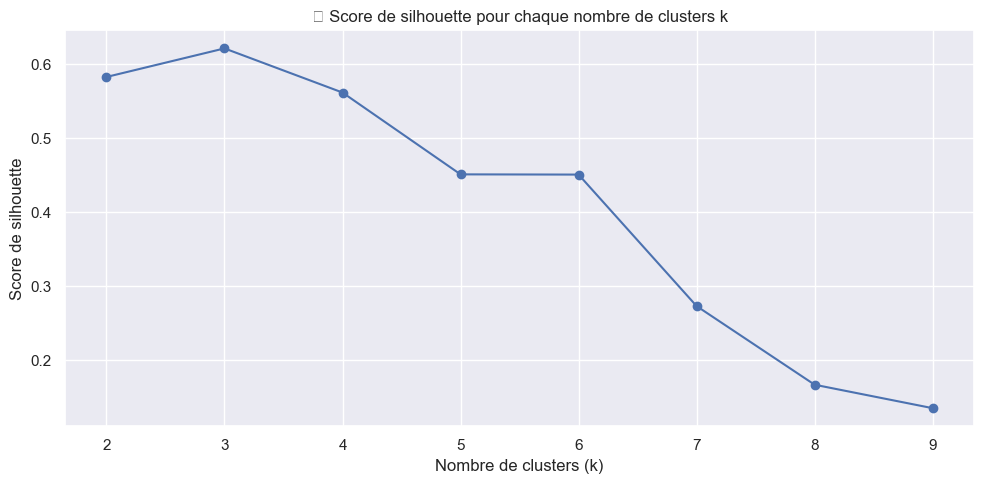


✅ Meilleur nombre de clusters : k=3 (score=0.6216)

📦 ➤ Custom profiles (copier-coller ready au format JSON-like):
custom_profiles = 
{
    "cluster_0": [
        0.973,
        0.085,
        0.009
    ],
    "cluster_1": [
        0.975,
        0.079,
        0.009
    ],
    "cluster_2": [
        0.971,
        0.09,
        0.011
    ]
}


In [65]:
silhouette_scores, best_k, kmeans_model, df_botnet_clustered, _ = find_best_k_with_silhouette(df_features_without_pre_cluster, k_range=range(2, 10))

In [67]:
plot_botnet_clusters_3D_plotly(df_botnet_clustered, kmeans_model)


📍 ➤ Coordonnées des centroïdes trouvés (features RU):
  ➤ Cluster 0 : RU_SrcPort=0.973, RU_DstPort=0.085, RU_DstIP=0.009
  ➤ Cluster 1 : RU_SrcPort=0.975, RU_DstPort=0.079, RU_DstIP=0.009
  ➤ Cluster 2 : RU_SrcPort=0.971, RU_DstPort=0.090, RU_DstIP=0.011


In [70]:
epsilon_dict = {
    'RU_SrcPort': 0.2,
    'RU_DstPort': 0.2,
    'RU_DstIP': 0.3
}
threshold = 0.4


df_classified = apply_threshold_and_categorize_ru(df_features, threshold=threshold, epsilon_dict=epsilon_dict)
df_classified_pre_clusters = apply_threshold_and_categorize_ru(df_features_without_pre_cluster, threshold=threshold, epsilon_dict=epsilon_dict)
display_scrollable_dataframe(df_classified, max_height=200)

,SrcIP,RU_SrcPort,RU_SrcPort_Level,RU_DstPort,RU_DstPort_Level,RU_DstIP,RU_DstIP_Level,AnomalyScore,Label,ClusterType,Distance_Scanner_simple,Distance_Scanner_bruyant,Distance_Victime_multiattaque,Distance_Scanner_intermediaire,Distance_Cible_botnet,Distance_Scanner_vertical,Predicted
0,147.32.84.118,0.880758,2,0.262773,1,0.806082,2,0.035686,Background,Significatif,0.644899,0.035686,1.024463,0.674681,0.065468,0.525417,Botnet
1,147.32.84.132,0.993698,2,0.404808,1,0.433739,1,0.213069,Background,Significatif,1.109004,0.319087,1.261312,1.025158,0.235240,0.213069,Botnet
2,147.32.84.138,0.993439,2,0.002507,0,0.002739,0,0.027695,Background,Significatif,1.612815,0.823313,2.408804,1.850809,1.061307,0.027695,Botnet
3,147.32.84.164,0.877382,2,0.389595,1,0.428427,1,0.192242,Normal,Significatif,0.910569,0.306758,1.087216,0.838892,0.235082,0.192242,Botnet
4,147.32.84.165,0.970355,2,0.092190,0,0.011203,0,0.012896,Botnet,Significatif,1.547539,0.794971,2.200036,1.713787,0.961220,0.012896,Botnet
5,147.32.84.170,0.993326,2,0.409853,1,0.385080,1,0.185989,Normal,Significatif,1.159183,0.369861,1.303418,1.071301,0.281979,0.185989,Botnet
6,147.32.84.191,0.972989,2,0.085044,0,0.010086,0,0.013636,Botnet,Significatif,1.554282,0.797499,2.218212,1.726247,0.969464,0.013636,Botnet
7,147.32.84.192,0.972890,2,0.084848,0,0.008962,0,0.013830,Botnet,Significatif,1.556114,0.799491,2.220358,1.728236,0.971613,0.013830,Botnet
8,147.32.84.193,0.971888,2,0.088307,0,0.010677,0,0.013283,Botnet,Significatif,1.551221,0.796199,2.209929,1.720575,0.965554,0.013283,Botnet
9,147.32.84.204,0.974572,2,0.079770,0,0.008767,0,0.014294,Botnet,Significatif,1.559583,0.800267,2.231951,1.735767,0.976451,0.014294,Botnet


In [ ]:
df_classified_netflows, df_grouped = classify_netflows_from_XU(df, df_classified, time_window='2Min')
display_scrollable_dataframe(df_classified_netflows.head(10), max_height=200)

[1/5] 📅 Vérification du format de la colonne 'flow_start'...
✅ 'flow_start' déjà au format datetime.
[2/5] 🕒 Attribution des TimeWindows...
[3/5] 🔗 Jointure des classifications par 'SrcIP'...
[4/5] 📊 Regroupement par 'SrcIP' et 'TimeWindow' (aggregation)...


→ Agrégation des netflows:   0%|          | 0/279506 [00:00<?, ?it/s]

In [ ]:
df_metrics, avg_metrics, df_ip = compute_time_weighted_metrics(df_grouped, take_background=True, alpha=0.01)

print(json.dumps(avg_metrics, indent=4))
display_scrollable_dataframe(df_metrics, max_height=400)

In [ ]:
plot_botnet_and_metrics_subplots(df_classified_netflows, df_metrics, x_tick_spacing=5)